# 00+01 — Data Overview & Prep (all-in-one)

This single notebook keeps things **simple** and uses your repo functions end‑to‑end:
- **Download** from Kaggle → `src.data.fetch.download_datasets`
- **Overview**: palette swatches, class distribution, samples per class (previewed in your 8‑color palette)
- **Preprocess**: resize → 8‑color → `labels.csv` via `src.data.prep.prepare_dataset`
- **After**: class distribution + samples from outputs, quick 16×16 check


In [1]:
# make repo importable (this notebook lives in /notebooks)
import sys, os
REPO_ROOT = os.path.abspath("..")
if REPO_ROOT not in sys.path:
    sys.path.append(REPO_ROOT)
print("repo root:", REPO_ROOT)


repo root: C:\Users\ruzgh\PycharmProjects\pixelart-ccgen


In [2]:
# --- config ---
RUN_DOWNLOAD = True                         # set False to skip download step
DATASET_SLUG = "ebrahimelgazar/pixel-art"   # Kaggle slug (owner/dataset)
RAW_DIR = "../data/raw"
OUT_DIR = "../data/clean_16x16"
PALETTE_JSON = "../palettes/global8.json"
TARGET_SIZE = (16, 16)
SAMPLES_PER_CLASS = 6
MAX_CLASSES_TO_SHOW = 6
CLEAN_OUTPUT_FIRST = False

# imports
from pathlib import Path
import random, shutil, csv, json
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from src.data.fetch import download_datasets
from src.data.prep import prepare_dataset, _load_palette, _quantize


In [3]:
# optional download
raw = Path(RAW_DIR)
empty = (not raw.exists()) or (len(list(raw.rglob('*'))) == 0)
if RUN_DOWNLOAD and empty:
    print("downloading:", DATASET_SLUG)
    download_datasets(DATASET_SLUG, out_dir=RAW_DIR)   # needs kaggle.json in your user home
else:
    print("skip download (RUN_DOWNLOAD=False or RAW not empty)")


skip download (RUN_DOWNLOAD=False or RAW not empty)


In [4]:
# helpers
def scan_classes(folder: str | Path):
    folder = Path(folder)
    exts = {".png",".jpg",".jpeg",".bmp",".gif"}
    classes = {}
    if not folder.exists():
        return classes
    subs = [d for d in folder.iterdir() if d.is_dir()]
    if subs:
        for d in sorted(subs):
            files = [p for p in d.rglob("*") if p.suffix.lower() in exts]
            if files: classes[d.name] = files
    else:
        files = [p for p in folder.rglob("*") if p.suffix.lower() in exts]
        if files: classes["pixel"] = files
    return classes

def plot_distribution(classes_dict, title):
    names = list(classes_dict.keys())
    counts = [len(classes_dict[k]) for k in names]
    if not names:
        print("no images found")
        return
    fig, ax = plt.subplots(figsize=(max(6, len(names)*0.8), 3.2))
    ax.bar(names, counts)
    ax.set_title(title)
    ax.set_ylabel("image count")
    ax.set_xticklabels(names, rotation=45, ha="right")
    plt.tight_layout(); plt.show()

def show_palette_swatches(palette_json):
    data = json.loads(Path(palette_json).read_text(encoding="utf-8"))
    cols = data.get("colors", data) if isinstance(data, dict) else data
    def to_rgb(c):
        if isinstance(c, str):
            s = c.strip().lstrip("#")
            if len(s)==3: s = "".join(ch*2 for ch in s)
            v = int(s,16); return ((v>>16)&255,(v>>8)&255,v&255)
        r,g,b = c; return (int(r),int(g),int(b))
    rgb = [to_rgb(c) for c in cols]
    fig, ax = plt.subplots(figsize=(max(6, len(rgb)*0.5), 1.2))
    for i,(r,g,b) in enumerate(rgb):
        ax.add_patch(plt.Rectangle((i,0),1,1,color=(r/255.0,g/255.0,b/255.0)))
    ax.set_xlim(0,len(rgb)); ax.set_ylim(0,1)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_title(f"Palette ({len(rgb)} colors)")
    plt.show()

def grid_samples(classes_dict, title, palette_json=None, per_class=6, max_classes=6):
    names = list(classes_dict.keys())
    if not names:
        print("no classes to show")
        return
    names = names[:max_classes]
    pal_flat = _load_palette(palette_json) if palette_json else None

    rows = len(names); cols = max(1, per_class)
    fig, axes = plt.subplots(rows, cols, figsize=(1.8*cols, 1.8*rows))
    if rows == 1: axes = np.array([axes])

    for r, cls in enumerate(names):
        files = classes_dict[cls][:]
        random.shuffle(files)
        pick = files[:cols]
        for c, p in enumerate(pick):
            ax = axes[r, c]
            try:
                im = Image.open(p)
                if pal_flat is not None:
                    im = _quantize(im, pal_flat)
                ax.imshow(im)
                ax.axis("off")
                if c == 0: ax.set_title(cls, fontsize=10, loc="left")
            except Exception:
                ax.axis("off")
        for c in range(len(pick), cols):
            axes[r, c].axis("off")
    fig.suptitle(title, y=1.02, fontsize=12)
    plt.tight_layout(); plt.show()


RAW classes: ['images'] | total imgs: 89400


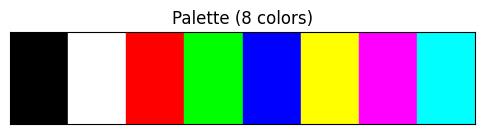

C:\Users\ruzgh\AppData\Local\Temp\ipykernel_9672\1347027838.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=45, ha="right")


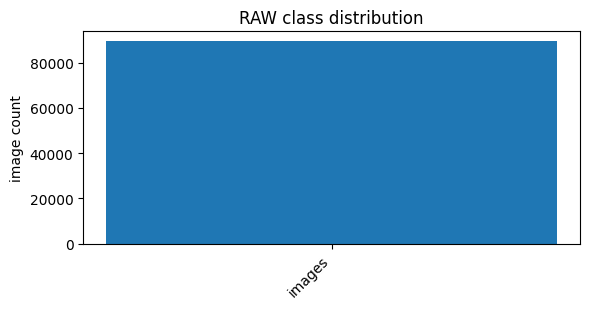

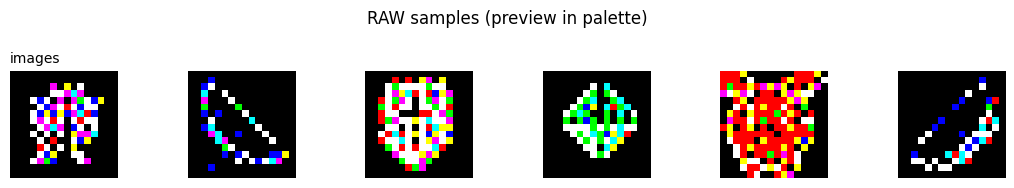

In [5]:
# BEFORE — RAW overview
raw_classes = scan_classes(RAW_DIR)
print("RAW classes:", list(raw_classes.keys())[:20], "| total imgs:", sum(len(v) for v in raw_classes.values()))
show_palette_swatches(PALETTE_JSON)
plot_distribution(raw_classes, "RAW class distribution")
grid_samples(raw_classes, title="RAW samples (preview in palette)",
             palette_json=PALETTE_JSON, per_class=SAMPLES_PER_CLASS, max_classes=MAX_CLASSES_TO_SHOW)


In [6]:
# RUN PREP
out = Path(OUT_DIR)
if CLEAN_OUTPUT_FIRST and out.exists():
    shutil.rmtree(out)

count = prepare_dataset(RAW_DIR, OUT_DIR, size=TARGET_SIZE, palette_json=PALETTE_JSON)
print("prepare_dataset wrote images:", count)


KeyboardInterrupt: 

In [ ]:
# AFTER — visualize outputs using labels.csv
out = Path(OUT_DIR)
labels_path = out / "labels.csv"
by_class = {}
if labels_path.exists():
    with open(labels_path, encoding="utf-8") as f:
        r = csv.DictReader(f)
        for row in r:
            by_class.setdefault(row["label"], []).append(out/"images"/row["filename"])

print("OUT classes:", list(by_class.keys())[:20], "| total imgs:", sum(len(v) for v in by_class.values()))
plot_distribution(by_class, "CLEAN_16x16 class distribution")
grid_samples(by_class, title="CLEAN_16x16 samples", palette_json=None,
             per_class=SAMPLES_PER_CLASS, max_classes=MAX_CLASSES_TO_SHOW)


In [ ]:
# sanity: verify shapes (16x16) and (optional) palette size on a few samples
from itertools import islice
mismatched = []
too_many_colors = []
imgs = list((Path(OUT_DIR)/"images").glob("*.png"))
for p in islice(imgs, 0, 100):
    try:
        with Image.open(p).convert("RGB") as im:
            if im.size != TARGET_SIZE:
                mismatched.append(p.name)
            # rough color count check (should be <= 8 if using 8-color palette)
            unique = len(set(im.getdata()))
            if unique > 8:
                too_many_colors.append((p.name, unique))
    except Exception:
        mismatched.append(p.name)

print("checked:", min(100, len(imgs)),
      "| size mismatched:", len(mismatched),
      "| >8 colors (sampled):", len(too_many_colors),
      ("examples: " + str(too_many_colors[:5]) if too_many_colors else ""))
